# Macroscopic response based on atomistic properties
<img src="sqs_wf.png"
     alt="Markdown Monster icon"
     style="float: center;" />
     
     
<img src="damask_wf.png"
     alt="Markdown Monster icon"
     style="float: center;" />
     
     
<img src="combined.png"
     alt="Markdown Monster icon"
     style="float: center;" />
## Concentration dependent elastic constants

Here we demonstrate the new `SQSElasticConstantsList` job, which gets elastic constants as a function of chemical composition.

This job works by using special quasirandom structures (implemented by Dominik Gehringer and Jan Janssen) to create cells with the requested chemical composition from a base crystal structure. These are then evaluated for their elastic constants (implemented by Yuri Lysogorskiy). These are fully relaxed and the basic output is the chemical composition and full 6x6 elastic matrix. (More detailed output is available from the underlying `SQSElasticConstants` job stored in HDF5, but user-friendly bindings are not currently implemented.)

These components were assembled together in a single job (implemented by Liam Huber) that takes a list of dictionaries giving the desired chemical compositions (e.g. `{'Al': 0.95, 'Mg': 0.04, '0': 0.01}` for 95% Aluminium 4% Magnesium and 1% vacancies) and three reference jobs: a `ref_ham` which says how the structures should be interpreted for forces and energies (e.g. a Lammps job with a particular potential) -- the structure of this job provides the base crystal upon which the chemical compositions are imposed -- and `ref_sqs` and `ref_elastic` which hold the input parameters for the SQS and elastic constant calculation components.

The current implementation only facilitates modal run modes and is not heavily tested. The example below takes less than 30 minutes on a single core, so for the purposes of demonstration this is not a serious limitation.

In [1]:
%matplotlib inline

In [2]:
from pyiron_atomistics import Project
import pyiron_gpl
import pyiron_continuum
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

In [3]:
pr = Project('elastic_pipeline')
pr.remove_jobs_silently(recursive=True)

## Run the calculation

Our test system will be Al with dilute Mg (up to 2%). Here we define the reference jobs, give our desired compositions.

### Minimize the structure for a pure `Al` cubic cell 

In [4]:
lmp_mini = pr.create_job(pr.job_type.Lammps, 'lammps_mini')
lmp_mini.structure = pr.create_ase_bulk('Al', cubic=True).repeat(5)
lmp_mini.potential = '2009--Mendelev-M-I--Al-Mg--LAMMPS--ipr1'
lmp_mini.calc_minimize(pressure=0.0)
lmp_mini.run()

The job lammps_mini was saved and received the ID: 98


### Creating quasirandom structure based on the minimized Al structure  
Based on a given concentration of `Mg`, quasirandom structure for the given composition of `Al` and `Mg` is created.

In [5]:
sqs_job_al = pr.create_job(
    job_type=pr.job_type.SQSJob, 
    job_name="sqs_job_al"
)
sqs_job_al.structure = lmp_mini.get_structure()
sqs_job_al.input['iterations'] = 1000
master_al = sqs_job_al.create_job(
    job_type=pr.job_type.SQSMaster, 
    job_name="master_al"
)

master_al.input["fraction_lst"] = [0.005, 0.01, 0.015, 0.02]
master_al.input["species_one"] = "Mg"
master_al.input["species_two"] = "Al"
master_al.run()

The job master_al was saved and received the ID: 99
The job sqs_0_005 was saved and received the ID: 100
Mole fractions were corrected to: {'Mg': 0.004, 'Al': 0.996}
Threads used: 1
The job sqs_0_01 was saved and received the ID: 101
Threads used: 1
The job sqs_0_015 was saved and received the ID: 102
Mole fractions were corrected to: {'Mg': 0.016, 'Al': 0.984}
Threads used: 1
The job sqs_0_02 was saved and received the ID: 103
Threads used: 1


In [6]:
concentration_lst = [0.0] + [0.005, 0.01, 0.015, 0.02]

In [7]:
structure_lst = [lmp_mini.get_structure()] + master_al.list_of_structures

In [8]:
[s.get_chemical_formula() for s in structure_lst]

['Al500', 'Al498Mg2', 'Al495Mg5', 'Al492Mg8', 'Al490Mg10']

### Creating ElasticMatrixJob
The `ElasticMatrixJob` runs underneath several lammps jobs to determine the elastic constant for the given structure.

In [9]:
for s in structure_lst:
    lmp_template = pr.create_job(pr.job_type.Lammps, 'lammps_tmp')
    lmp_template.potential = '2009--Mendelev-M-I--Al-Mg--LAMMPS--ipr1'
    lmp_template.server.run_mode.interactive = True
    lmp_template.interactive_enforce_structure_reset = True
    lmp_template.structure = s
    elastic = lmp_template.create_job(pr.job_type.ElasticMatrixJob, 'elastic_' + s.get_chemical_formula())
    elastic.input['num_of_points'] = 5
    elastic.input['fit_order'] = 2
    elastic.input['eps_range'] = 0.005
    elastic.input['relax_atoms'] = True
    elastic.input['sqrt_eta'] = True
    elastic.run()

The job elastic_Al500 was saved and received the ID: 104
The job elastic_Al500_lammps_tmp was saved and received the ID: 105


/home/muhammad/miniconda3/envs/workshop_test/lib/python3.8/site-packages/pyiron_atomistics/lammps/interactive.py:375: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(


The job elastic_Al498Mg2 was saved and received the ID: 106
The job elastic_Al498Mg2_lammps_tmp was saved and received the ID: 107
The job elastic_Al495Mg5 was saved and received the ID: 108
The job elastic_Al495Mg5_lammps_tmp was saved and received the ID: 109
The job elastic_Al492Mg8 was saved and received the ID: 110
The job elastic_Al492Mg8_lammps_tmp was saved and received the ID: 111
The job elastic_Al490Mg10 was saved and received the ID: 112
The job elastic_Al490Mg10_lammps_tmp was saved and received the ID: 113


## post-processing the data
A very useful, datamining tool in pyiron is pyiron tables. They can search through the jobs and filter based on the query the necessary information in the form of a table.  

First, let's take a look at the job table.


In [10]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,98,finished,Al500,lammps_mini,/lammps_mini,/home/muhammad/,workspace/tmp/PMD-workflow-workshop2/3_lammps_damask_workflow/elastic_pipeline/,2021-04-29 00:39:45.740226,2021-04-29 00:39:46.235415,0.0,pyiron@cmleo14#1,Lammps,0.1,None,NaN
1,99,finished,Al500,master_al,/master_al,/home/muhammad/,workspace/tmp/PMD-workflow-workshop2/3_lammps_damask_workflow/elastic_pipeline/,2021-04-29 00:39:47.199526,2021-04-29 00:39:50.651729,3.0,pyiron@cmleo14#1#4/4,SQSMaster,0.0.1,None,NaN
2,100,finished,Al498Mg2,sqs_0_005,/sqs_0_005,/home/muhammad/,workspace/tmp/PMD-workflow-workshop2/3_lammps_damask_workflow/elastic_pipeline/master_al_hdf5/,2021-04-29 00:39:47.599948,2021-04-29 00:39:48.075268,0.0,pyiron@cmleo14#1,SQSJob,0.1,None,99.0
3,101,finished,Al495Mg5,sqs_0_01,/sqs_0_01,/home/muhammad/,workspace/tmp/PMD-workflow-workshop2/3_lammps_damask_workflow/elastic_pipeline/master_al_hdf5/,2021-04-29 00:39:48.427215,2021-04-29 00:39:48.870143,0.0,pyiron@cmleo14#1,SQSJob,0.1,None,99.0
4,102,finished,Al492Mg8,sqs_0_015,/sqs_0_015,/home/muhammad/,workspace/tmp/PMD-workflow-workshop2/3_lammps_damask_workflow/elastic_pipeline/master_al_hdf5/,2021-04-29 00:39:49.232829,2021-04-29 00:39:49.687223,0.0,pyiron@cmleo14#1,SQSJob,0.1,None,99.0
5,103,finished,Al490Mg10,sqs_0_02,/sqs_0_02,/home/muhammad/,workspace/tmp/PMD-workflow-workshop2/3_lammps_damask_workflow/elastic_pipeline/master_al_hdf5/,2021-04-29 00:39:50.049933,2021-04-29 00:39:50.634892,0.0,pyiron@cmleo14#1,SQSJob,0.1,None,99.0
6,104,finished,Al500,elastic_Al500,/elastic_Al500,/home/muhammad/,workspace/tmp/PMD-workflow-workshop2/3_lammps_damask_workflow/elastic_pipeline/,2021-04-29 00:39:55.202153,2021-04-29 00:39:59.327718,4.0,pyiron@cmleo14#1#0,ElasticMatrixJob,0.0.1,None,NaN
7,105,finished,Al500,elastic_Al500_lammps_tmp,/elastic_Al500_lammps_tmp,/home/muhammad/,workspace/tmp/PMD-workflow-workshop2/3_lammps_damask_workflow/elastic_pipeline/,2021-04-29 00:39:55.967242,2021-04-29 00:39:58.445134,2.0,pyiron@cmleo14#1,Lammps,0.1,None,104.0
8,106,finished,Al498Mg2,elastic_Al498Mg2,/elastic_Al498Mg2,/home/muhammad/,workspace/tmp/PMD-workflow-workshop2/3_lammps_damask_workflow/elastic_pipeline/,2021-04-29 00:40:00.037555,2021-04-29 00:40:18.600354,18.0,pyiron@cmleo14#1#0,ElasticMatrixJob,0.0.1,None,NaN
9,107,finished,Al498Mg2,elastic_Al498Mg2_lammps_tmp,/elastic_Al498Mg2_lammps_tmp,/home/muhammad/,workspace/tmp/PMD-workflow-workshop2/3_lammps_damask_workflow/elastic_pipeline/,2021-04-29 00:40:00.500052,2021-04-29 00:40:17.934727,17.0,pyiron@cmleo14#1,Lammps,0.1,None,106.0


### filtering jobs
By the `filter_function`, from the `pr.job_table()` we filter the jobs with name `elastic_*` and not the template lammps jobs.

In [11]:
def filter_function(job): 
    return "elastic_" in job.job_name and "lammps_tmp" not in job.job_name

## Obtaining elastic moduli
`get_c11`, `get_c12` and `get_c44` functions, look into the queried jobs of the `filter_function` and obtain the elastic moduli from the jobs. 

In [12]:
def get_c11(job):
    return job["output/elasticmatrix"]["C"][0,0]

def get_c12(job):
    return job["output/elasticmatrix"]["C"][0,1]

def get_c44(job):
    return job["output/elasticmatrix"]["C"][3,3]

In [13]:
table = pr.create_table()

In [14]:
table.filter_function = filter_function
table.add["C11"] = get_c11
table.add["C12"] = get_c12
table.add["C44"] = get_c44

In [15]:
table.run()

 20%|██        | 1/5 [00:00<00:00,  8.98it/s]

The job table was saved and received the ID: 114


100%|██████████| 5/5 [00:01<00:00,  3.00it/s]


In [16]:
df_data = table.get_dataframe()
df_data

,job_id,C11,C12,C44
0,104,110.193270,61.752630,32.746691
1,106,111.879613,62.840538,33.243125
2,108,113.043400,64.484805,34.110036
3,110,114.186882,66.304002,34.947656
4,112,115.628680,67.263743,35.473180


## Analysis

Finally, let's use numpy to make a polynomial fit of our elastic constants to alloying concentration and visualize the results.

Note: pure-Al data lines up very nicely with the pure Al elastic constants [reported on the NIST website for this potential](https://www.ctcms.nist.gov/potentials/entry/2009--Mendelev-M-I-Asta-M-Rahman-M-J-Hoyt-J-J--Al-Mg/2009--Mendelev-M-I--Al-Mg--LAMMPS--ipr1.html).

In [17]:
concentrations = np.array(concentration_lst)

In [18]:
C11_data = df_data["C11"].values
C12_data = df_data["C12"].values
C44_data = df_data["C44"].values

In [19]:
fit_degree = 2
C11_fit = np.polyfit(concentrations, C11_data, deg=fit_degree)
C12_fit = np.polyfit(concentrations, C12_data, deg=fit_degree)
C44_fit = np.polyfit(concentrations, C44_data, deg=fit_degree)
c = np.linspace(concentrations.min(), concentrations.max(), 100)  # 'Continuous' concentration

In [20]:
# p(x) = p[0] * x**deg + ... + p[deg]
print(C11_fit)
print(C12_fit)
print(C44_fit)

[-1455.41215732   292.67002594   110.27798032]
[-232.58951752  294.36557718   61.62037628]
[ 82.53942106 141.49939749  32.67676254]


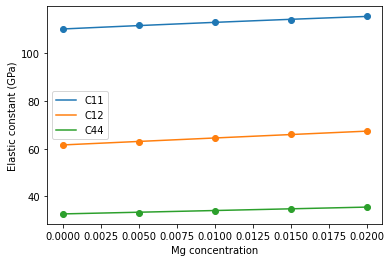

In [21]:
for color, data, fit, label in zip(
    sns.color_palette(n_colors=3), 
    [C11_data, C12_data, C44_data], 
    [C11_fit, C12_fit, C44_fit],
    ['C11', 'C12', 'C44']
):
    plt.scatter(concentrations, data, color=color)
    plt.plot(c, np.polyval(fit, c), color=color, label=label)
plt.xlabel('Mg concentration')
plt.ylabel('Elastic constant (GPa)')
plt.legend()
plt.show()

## DAMASK Simulations
The steps include, defining:
- geometries
- grains
- loading
- material properties based on the atomistically-evaluated 
- perfoming simulations

In [22]:
concentration_sample = [concentrations[0],concentrations[-1]]

In [23]:
with open('../pyiron/resources/damask/material.yaml') as f:
    material = yaml.load(f, Loader=yaml.FullLoader)
with open('../pyiron/resources/damask/tensionX.load') as f:
    tension = f.readlines()

### Exercise: 
In order to create DAMASK jobs for the given number of concentration, please fill in the missing line. 

In [24]:
job_lst = []
for i,c in enumerate(concentration_sample):
    job = pr.create_job(pr.job_type.DAMASKjob, "damask_" + 'mg_{}'.format(int(c*100)))
    job.material = material
    job.tension = tension
    job.input['C11'] = float(np.polyval(C11_fit, c))
    job.input['C12'] = float(np.polyval(C12_fit, c))
    job.input['C44'] = float(np.polyval(C44_fit, c))
    job.run()
    job_lst.append(job)

The job damask_mg_0 was saved and received the ID: 115
The job damask_mg_2 was saved and received the ID: 116


## Post-processing DAMASK simulations
- Von-Mises stress for each case is calculated
- The Stress-strain data is evaluated for each case


In [25]:
stresses, strains = [], []
for job in job_lst: 
    damask_results = job.output
    damask_results.add_stress_Cauchy()
    damask_results.add_strain()
    damask_results.add_equivalent_Mises('sigma')
    damask_results.add_equivalent_Mises('epsilon_V^0.0(F)')
    damask_results.add_calculation('avg_sigma',"np.average(#sigma_vM#)")
    damask_results.add_calculation('avg_epsilon',"np.average(#epsilon_V^0.0(F)_vM#)")
    damask_results.save_VTK(['sigma','epsilon_V^0.0(F)','sigma_vM','epsilon_V^0.0(F)_vM'])
    stresses.append(job.eval_stress())
    strains.append(job.eval_strain())

 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00


## Visualization
### Von-Mises Stress

In [26]:
import os

In [27]:
import pyvista as pv
inc=20
mesh = pv.read(os.path.basename(job.output_file.split('.')[0]) + f'_inc0{inc}.vtr')  #enter the file name you wish to view

In [28]:
from itkwidgets import view
import itk
mesh

RectilinearGrid (0x7f5baf9079a0)
  N Cells:	4096
  N Points:	4913
  X Bounds:	0.000e+00, 1.000e+00
  Y Bounds:	0.000e+00, 1.000e+00
  Z Bounds:	0.000e+00, 1.000e+00
  Dimensions:	17, 17, 17
  N Arrays:	5

In [29]:
pl = pv.PlotterITK()
pl.add_mesh(mesh)
pl.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

### Stress-strain curve

In [30]:
%matplotlib inline

Text(0.5, 1.0, 'Stress-Strain')

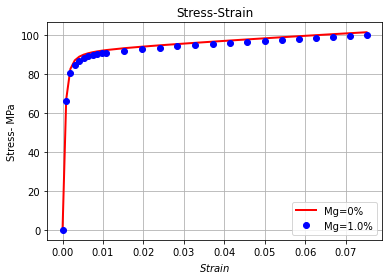

In [31]:
i = 0;
colors = ['r','g','b']
#for color, strain, stress, c in zip(colors, strains, stresses, concentrations):
plt.plot(strains[0], stresses[0], 'r', linewidth=2, label = 'Mg={}%'.format(0*100))
plt.plot(strains[1], stresses[1], 'b', linestyle="None",marker = 'o' ,label = 'Mg={}%'.format(0.01*100))
#plt.plot(strains[1], stresses[2], 'g', linestyle="None",marker = '*' ,label = 'Mg={}%'.format(0.02*100))
#plt.ylim(90, 95)
plt.grid(True)
plt.xlabel('$Strain$')
plt.ylabel('Stress- MPa')
plt.legend( loc='lower right')
plt.title("Stress-Strain")
 #   i= i+1;